# Import the library

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import numpy as np
from community import community_louvain

# Import the dataset

In [3]:
nodes_names = pd.DataFrame()
dataset = open('data/out.github', 'r')

In [4]:
repository_names = pd.read_csv('data/ent.github.repository.name', names=['repository'], header=None)
nodes_names[['users', 'projects']] = repository_names.repository.str.split('/', 1, expand=True)
nodes_names['name'] = repository_names.index+1
G = bipartite.parse_edgelist(dataset, nodetype=int, delimiter=' ', comments='%')

In [5]:
def graph_description(graph):
  """
  Describe a graph

  Parameters
  ------------
  graph: Networkx graph
  """
  # Network modularity and community detection
  partitions = community_louvain.best_partition(graph)
  net_mod = community_louvain.modularity(partitions, graph)  
  print("Connected:", nx.is_connected(graph))
  print("Mean clustering coefficient:", round(nx.average_clustering(graph),4))
  print("Density:", round(nx.density(graph),4))
  print("Modularity:", round(net_mod,4))
  print("Communities:", len(set(partitions.values())))
  print("Isolated Nodes:", len(list(nx.isolates(graph))))
  print('-' * 35)
  print(nx.info(graph))
  print("\n*****The number of connected components:", nx.number_connected_components(graph))
    
graph_description(G)
u_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
p_nodes = set(G) - u_nodes
print("The number of users:",len(u_nodes))
print("The number of projects:",len(p_nodes))
print("The bipartite density of users: ", bipartite.density(G, u_nodes))
print("The bipartite density of projects: ", bipartite.density(G, p_nodes))

Connected: False
Mean clustering coefficient: 0.0061
Density: 0.0001
Modularity: 0.4171
Communities: 972
Isolated Nodes: 0
-----------------------------------
Name: 
Type: Graph
Number of nodes: 120867
Number of edges: 439930
Average degree:   7.2796

*****The number of connected components: 3
The number of users: 40968
The number of projects: 79899
The bipartite density of users:  0.00013439944399243608
The bipartite density of projects:  0.00013439944399243608


# Data preprocessing
Networkx doesn't handle large-scale networks. For the seek of computation, we have to reduce the network

In [6]:
# to make thing simple we will work with the biggest subgraph
sorted_subgraphs = sorted(nx.connected_components(G), key=len, reverse=True)
#The biggest subgraph
B = G.subgraph(sorted_subgraphs[0])
print("The biggest subgraph description:")
graph_description(B)

#get nodes
u_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
p_nodes = set(B) - u_nodes

# get the degree for each node type
df_nodes_degree = pd.DataFrame(list(nx.degree(B)), columns=['node', 'degree'])
df_users_degree = df_nodes_degree[df_nodes_degree['node'].isin(B)]
df_projects_degree = df_nodes_degree[df_nodes_degree['node'].isin(B)]


The biggest subgraph description:
Connected: True
Mean clustering coefficient: 0.0061
Density: 0.0001
Modularity: 0.4256
Communities: 1601
Isolated Nodes: 0
-----------------------------------
Name: 
Type: Graph
Number of nodes: 120865
Number of edges: 439928
Average degree:   7.2797

*****The number of connected components: 1


In [7]:
# Select nodes to remove
users_to_remove = df_users_degree[( 3 > df_users_degree['degree']) | (df_users_degree['degree'] > 10)]["node"]
projects_to_remove = df_projects_degree[( 3 > df_projects_degree['degree']) | (df_projects_degree['degree'] > 10)]["node"]
# Remove these nodes
B_reduced = B.copy()

users_to_remove.append(projects_to_remove)
B_reduced.remove_nodes_from(users_to_remove)

graph_description(B_reduced)

Connected: False
Mean clustering coefficient: 0.0001
Density: 0.0
Modularity: 0.9941
Communities: 15513
Isolated Nodes: 11809
-----------------------------------
Name: 
Type: Graph
Number of nodes: 31846
Number of edges: 17008
Average degree:   1.0681

*****The number of connected components: 15474


In [8]:
# we keep the largest subgraph
sorted_subgraphs_reduced = sorted(nx.connected_components(B_reduced), key=len, reverse=True)
M = B_reduced.subgraph(sorted_subgraphs_reduced[0])
graph_description(M)

Connected: True
Mean clustering coefficient: 0.0
Density: 0.0004
Modularity: 0.9696
Communities: 74
Isolated Nodes: 0
-----------------------------------
Name: 
Type: Graph
Number of nodes: 4817
Number of edges: 5120
Average degree:   2.1258

*****The number of connected components: 1


In [9]:
#get nodes
users_nodes = {n for n, d in M.nodes(data=True) if d["bipartite"] == 0}
projects_nodes = set(M) - users_nodes
# get users and projects graph by projection
M_users = bipartite.projected_graph(M, users_nodes)
M_projects = bipartite.projected_graph(M, projects_nodes)

#add name attribute
users_node_attr = nodes_names.set_index('name')['users'].to_dict()
projects_node_attr = nodes_names.set_index('name')['projects'].to_dict()
nx.set_node_attributes(M_users, users_node_attr, 'name')
nx.set_node_attributes(M_projects, projects_node_attr, 'name')


In [10]:
def plot_bipartite_graph(graph, set_nodes1, set_nodes2):
  """
  Plot bipartite network using networkx
  Parameters
  ----------------------
  graph: bipartite network
  set_nodes1: set of nodes with bipartite=0
  set_nodes2: set of nodes with bipartite=1

  Returns
  -----------------------
  Networkx bipartite graph
  """
  # Plot size
  plt.rcParams.update({'font.size': 15})
  plt.subplots(figsize=(20,10))
  # Color list
  color_list = []
  for node in graph.nodes():
      if node in set_nodes1:
          color_list.append('r')
      else:
          color_list.append('g')

  # Sping layout
  nx.draw_networkx(graph, pos = nx.spring_layout(graph), node_size=40, font_size=15,
                    node_color= color_list, with_labels = False,
                    edge_color = 'gray', alpha=0.4)
  plt.axis("off")
  plt.show()

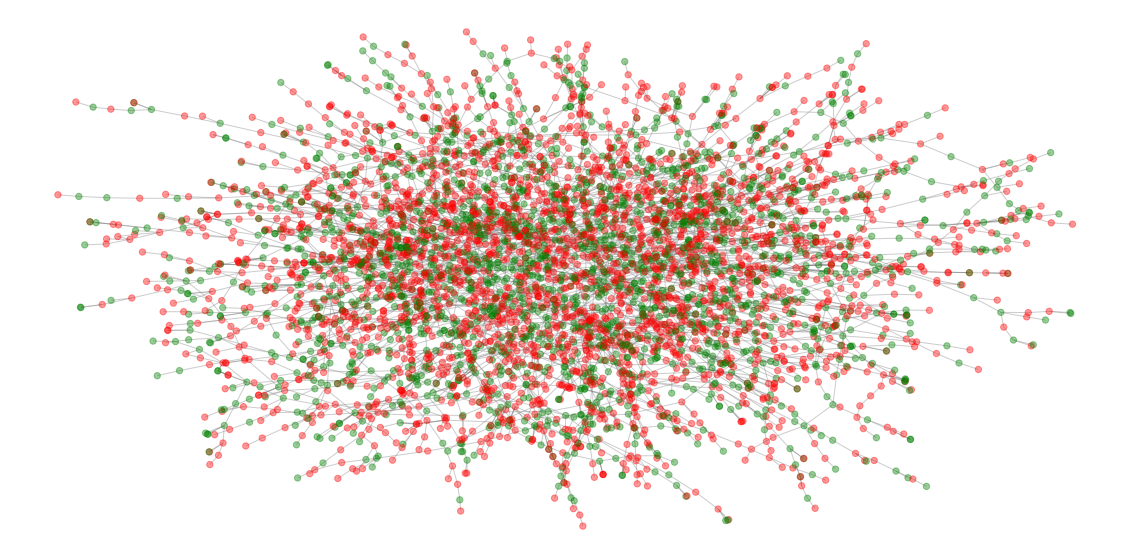

In [11]:
plot_bipartite_graph(M, users_nodes, projects_nodes)

# Work with unipartite graph users

In [12]:
graph_description(M_users)

Connected: False
Mean clustering coefficient: 0.395
Density: 0.0006
Modularity: 0.9794
Communities: 187
Isolated Nodes: 0
-----------------------------------
Name: 
Type: Graph
Number of nodes: 4529
Number of edges: 6656
Average degree:   2.9393

*****The number of connected components: 135


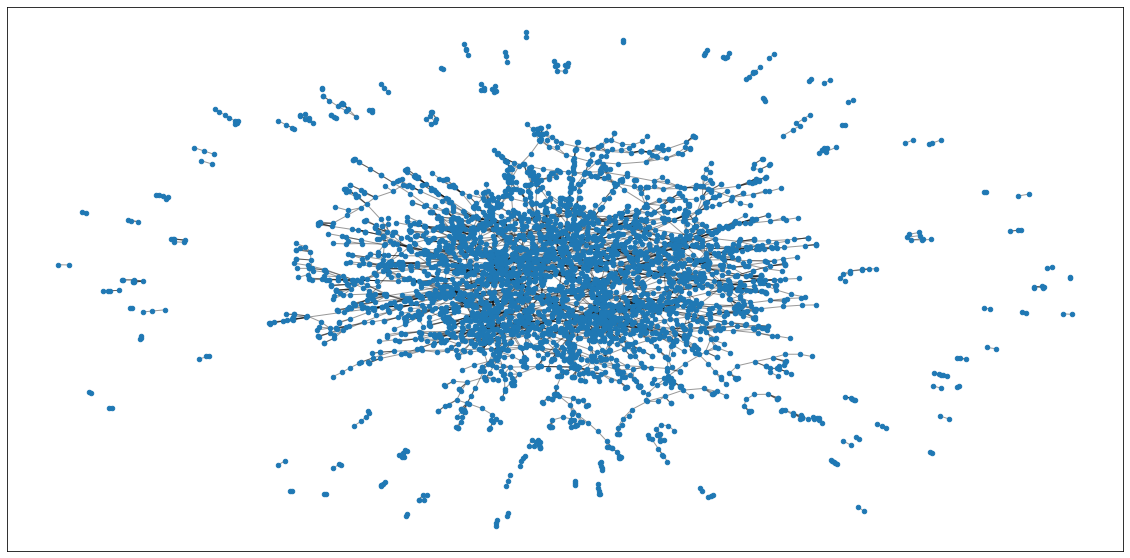

In [13]:
# display the graph
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(M_users)
nx.draw_networkx_nodes(M_users, pos, node_size=20)
nx.draw_networkx_edges(M_users, pos, alpha=0.4)
plt.show()

In [14]:
# community  detection using louvain algorithm
def plot_community_graph(graph):
  """
  Plot community detection
  Parameters
  -------------------
  G: Networkx graph
  Returns
  -------------------
  Networkx graph
  """
  # Set plot size
  plt.rcParams.update({'font.size': 15})
  plt.subplots(figsize=(20,10))

  # Community detection
  partitions = community_louvain.best_partition(graph)
  values = [partitions.get(node) for node in graph.nodes()]

  nx.draw_networkx(graph, pos = nx.spring_layout(graph),node_size=40, 
                   font_size=15, with_labels = False,
                    node_color= values, edge_color = 'gray')
  plt.show()

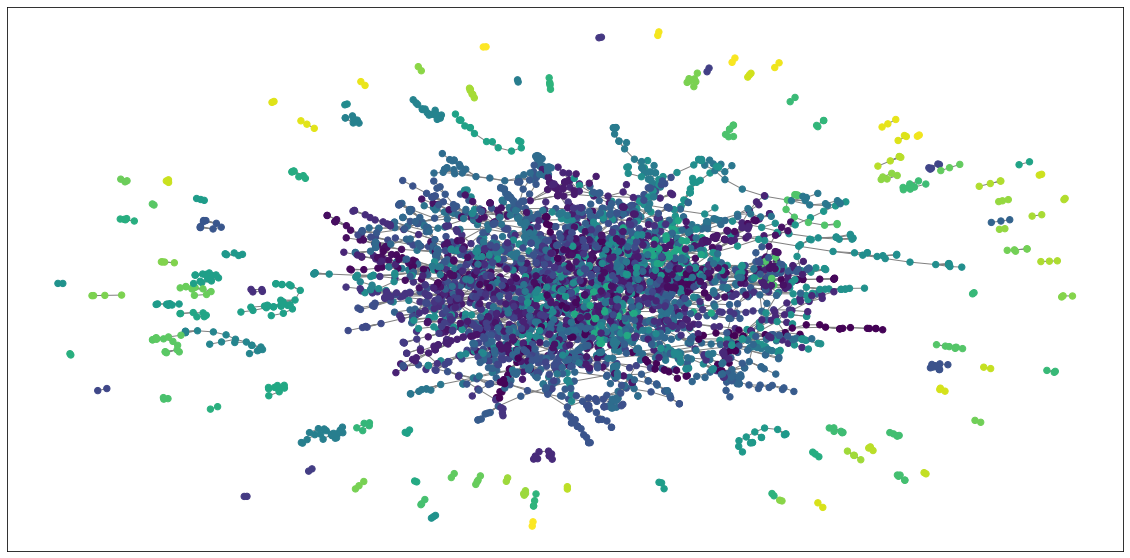

In [15]:
plot_community_graph(M_users)

# Work with unipartite graph of project

In [ ]:
graph_description(M_projects)

In [ ]:
# display the graph
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(M_projects)
nx.draw_networkx_nodes(M_projects, pos, node_size=20)
nx.draw_networkx_edges(M_projects, pos, alpha=0.4)
plt.show()

# Community detection